In [26]:
# Set up imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

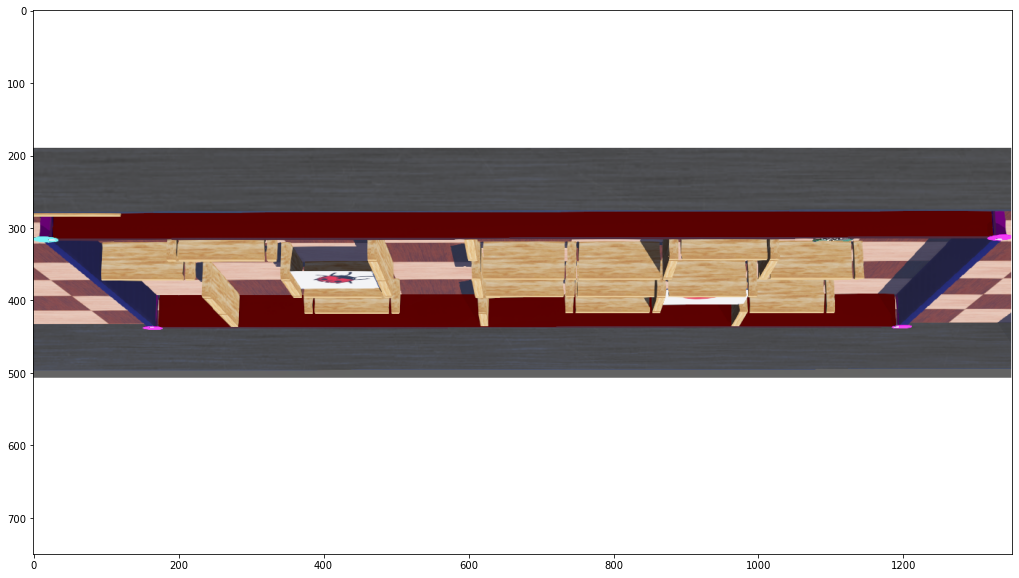

In [27]:
# Loads the raw map image and displays it
img = cv.imread('../James/Maze_test_A.png')
disp_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Load the robot and target images
robot_img = cv.imread('../James/Robot_test_A.png')
ladybug_img = cv.imread('../Ladybug_small.png')

plt.figure(figsize=(20,10))
plt.imshow(disp_img)
plt.show()

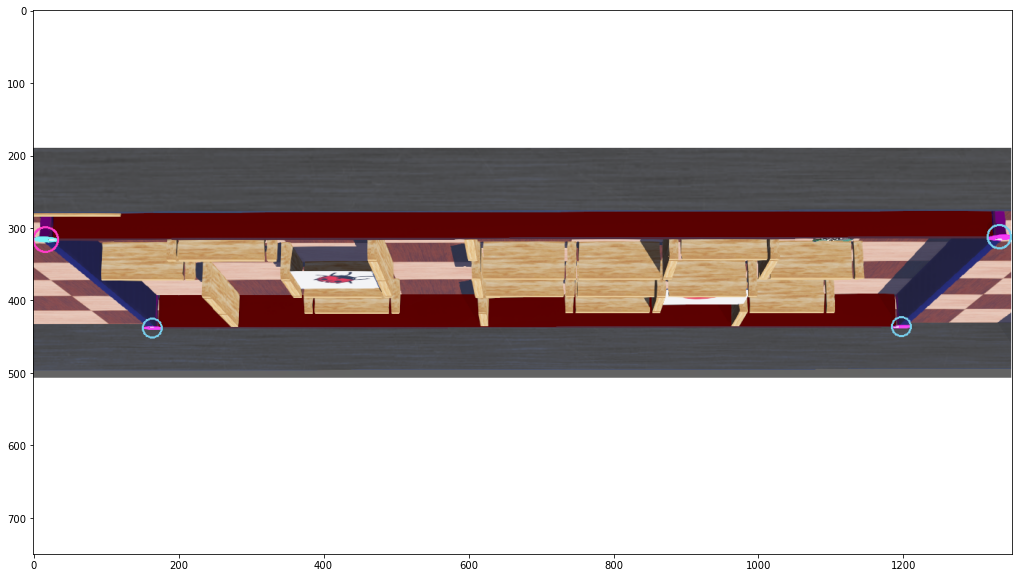

In [28]:
disp_img_marked = disp_img.copy()
# Finds the corner posts by colour searching the image
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
tl_mask = cv.inRange(img_hsv, (85,100,200), (95,255,255))
oth_mask = cv.inRange(img_hsv, (145,100,200), (155,255,255))

# Gets the minimum bounding circles of the regions in the masks
# Ignores the small circles by ignoring radius
# More consistent than using HoughCircle becuase of the warped circles when moving camera
_, tl_contour, _ = cv.findContours(tl_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
_, oth_contour, _ = cv.findContours(oth_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(tl_contour):
    poly = cv.approxPolyDP(c, 3, True)
    centre, radius = cv.minEnclosingCircle(poly)
    if radius > 6:
        tl_centre = centre
        tl_radius = radius
oth_centres = []
oth_radius = []
for i, c in enumerate(oth_contour):
    poly = cv.approxPolyDP(c, 3, True)
    centre, radius = cv.minEnclosingCircle(poly)
    if radius > 6:
        oth_centres.append(centre)
        oth_radius.append(radius)

# Marks the circles on the image
cv.circle(disp_img_marked, (int(tl_centre[0]), int(tl_centre[1])), int(tl_radius), (255,60,200), 2)
for i in range(len(oth_centres)):
    cv.circle(disp_img_marked, (int(oth_centres[i][0]), int(oth_centres[i][1])), int(oth_radius[i]), (120,206,235), 2)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(disp_img_marked)
plt.show()

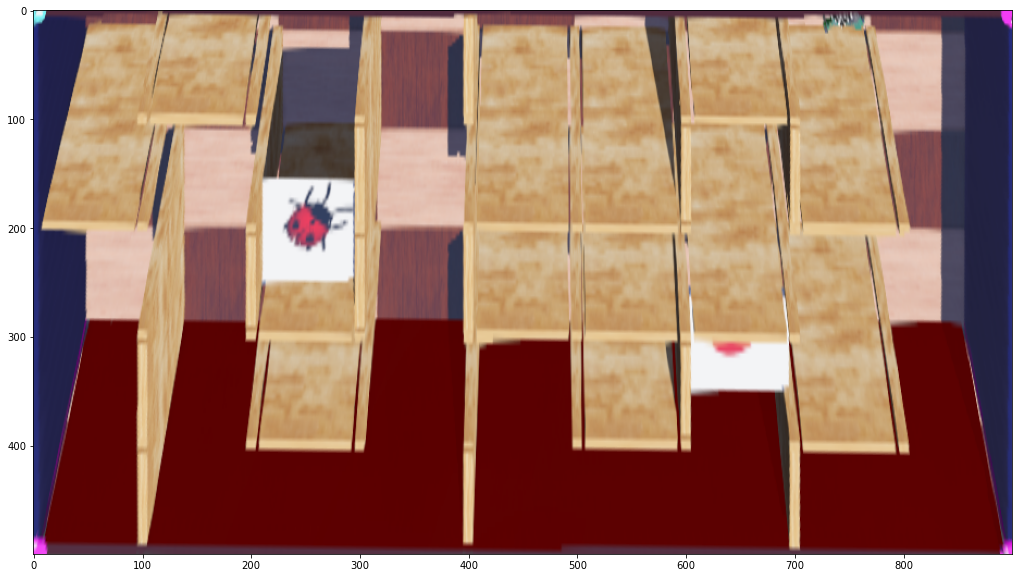

In [29]:
disp_img_trans = disp_img.copy()
# Finds the positions of all the circles in relation to the given regions
circles_xy = np.vstack([tl_centre, oth_centres])
tl_circle = [c for c in circles_xy if c[0] < 337.5 and c[1] < 375][0]
bl_circle = [c for c in circles_xy if c[0] < 337.5 and c[1] > 375][0]
tr_circle = [c for c in circles_xy if c[0] > 1012.5 and c[1] < 375][0]
br_circle = [c for c in circles_xy if c[0] > 1012.5 and c[1] > 375][0]

# Orders them correctly for the orientation of the image
# Assumes given assumption that blue circle is in region A or D
if tl_centre[0] > 1012.5 and tl_centre[1] > 375:
    ordered_circles = np.float32([br_circle, bl_circle, tr_circle, tl_circle])
    inverse = True
else:
    ordered_circles = np.float32([tl_circle, tr_circle, bl_circle, br_circle])
    inverse = False

# Defines the new perspective of the image
new_points = np.float32([[0, 0], [900, 0], [0, 500], [900, 500]])
trans = cv.getPerspectiveTransform(ordered_circles, new_points)
disp_img_trans = cv.warpPerspective(cv.cvtColor(disp_img_trans, cv.COLOR_RGB2BGR), trans, (900,500))
disp_img_trans = cv.cvtColor(disp_img_trans, cv.COLOR_RGB2BGR)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(disp_img_trans)
plt.show()

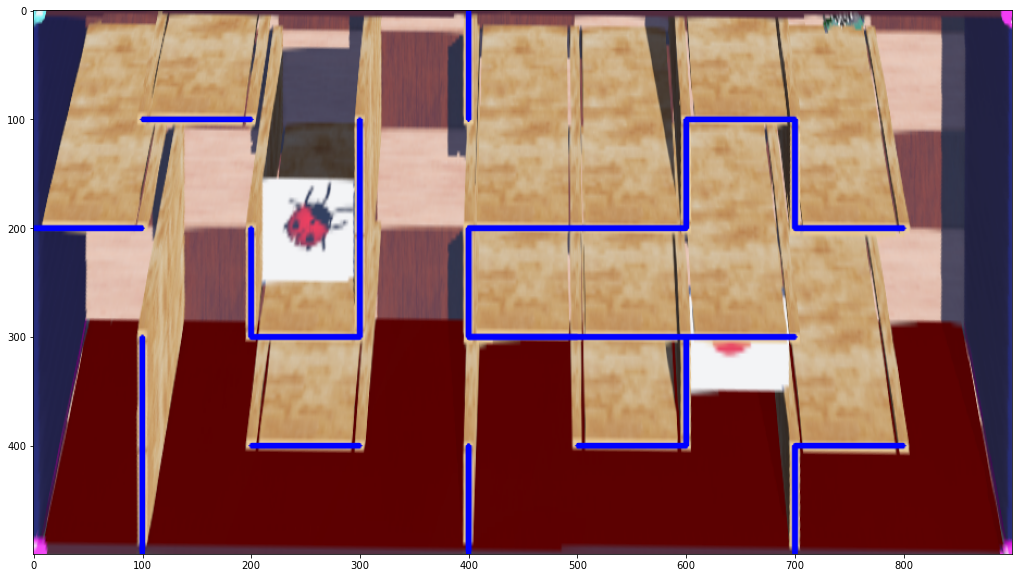

In [30]:
disp_img_lines = disp_img_trans.copy()
# Grab only the tops of walls from the rest of the image
trans_img_hsv = cv.cvtColor(disp_img_lines, cv.COLOR_RGB2HSV)
wall_mask = cv.inRange(trans_img_hsv, (15,60,220), (20,255,255))

# Detect the edges of the new image
edges = cv.Canny(wall_mask, 100, 200)
lines = cv.HoughLinesP(edges, 1, np.pi/180, 40, None, 50, 50)

# Normalise the lines, then remove any duplicates
nlines = []
for i in range(len(lines)):
    nlines.append(tuple(int(round(x,-2)) for x in lines[i][0]))
nlines = list(set(nlines))

# Draw the lines on the image
for l in nlines:
    cv.line(disp_img_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(disp_img_lines)
plt.show()

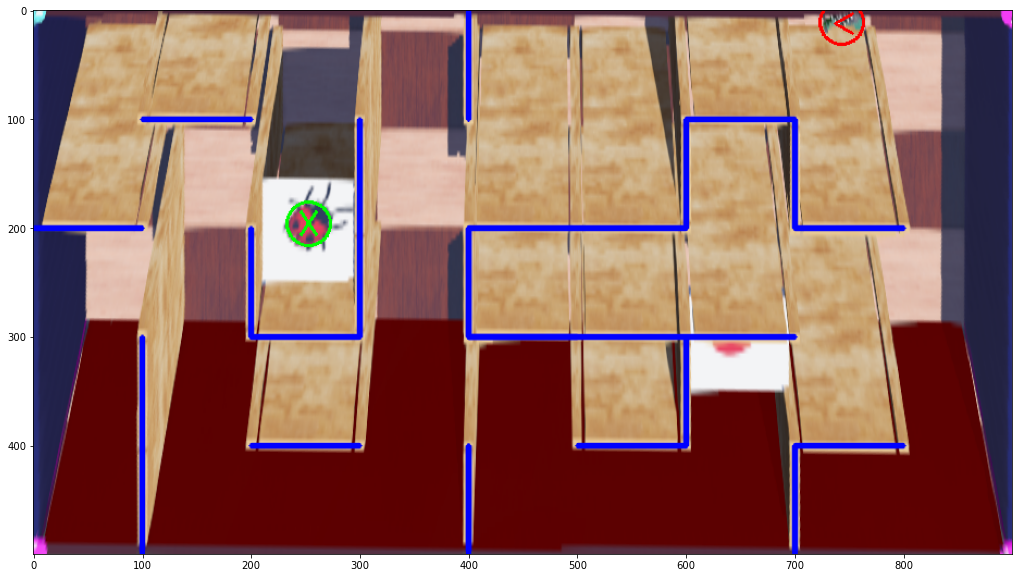

In [31]:
disp_img_found = disp_img_lines.copy()

# Work on target image to improve matching
target_img = cv.cvtColor(cv.resize(ladybug_img, (100,100)), cv.COLOR_BGR2RGB)

# Find locations of ladybugs in the picture by HSV search
target_mask = cv.inRange(cv.cvtColor(disp_img_found, cv.COLOR_RGB2HSV), (170,160,150), (180,255,255))
_, target_contour, _ = cv.findContours(target_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
actual_locations = []
target_locations = []
for i, c in enumerate(target_contour):
    poly = cv.approxPolyDP(c, 3, True)
    centre, radius = cv.minEnclosingCircle(poly)
    if radius > 10:
        actual_locations.append(centre)
        target_locations.append(((int(centre[0]//100*100)), int(centre[1]//100*100)))

best_matches = 0
best_i = 0
surf = cv.xfeatures2d.SURF_create()
kp_1, desc_1 = surf.detectAndCompute(target_img, None)
for i, l in enumerate(actual_locations):
    y, x = (int(l[0]-50), int(l[1]-50))
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    curr_img = disp_img_found.copy()[x:x+100, y:y+100]
    kp_2, desc_2 = surf.detectAndCompute(curr_img, None)
    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(desc_1,desc_2)
    matches = sorted(matches, key = lambda x:x.distance)
    if len(matches) > best_matches:
        best_matches = len(matches)
        best_i = i
    # Code to display matches, comment out if interested in SURF matching
    # print(len(matches))
    # match_img = cv.drawMatches(target_img, kp_1, curr_img, kp_2, matches[:50], None)
    # plt.imshow(match_img)
    # plt.show()
target_x, target_y = target_locations[best_i]

# Finds the robot location by looking for its colour
robot_mask = cv.inRange(cv.cvtColor(disp_img_found, cv.COLOR_RGB2HSV), (30,0,0), (105,130,200))
_, robot_contour, _ = cv.findContours(robot_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# Averages co-ordinates and sums radius to find final robot position
# This is done as with some difficult images, robot is detected with multiple small sections
robot_x = []
robot_y = []
robot_radius = []
for i, c in enumerate(robot_contour):
    poly = cv.approxPolyDP(c, 3, True)
    centre, radius = cv.minEnclosingCircle(poly)
    if radius > 5:
        robot_x.append(centre[0])
        robot_y.append(centre[1])
        robot_radius.append(radius)
robot_x = int(sum(robot_x)/len(robot_x))
robot_y = int(sum(robot_y)/len(robot_y))
robot_radius = sum(robot_radius)

# Finds the rotation of the robot by looking for corners of QR code
# Uses given higher-res robot image for better detection
dictionary = cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250)
parameters = cv.aruco.DetectorParameters_create()
corners, ids, rejects = cv.aruco.detectMarkers(robot_img, dictionary, parameters=parameters)
# Finds the corner on the square to represent heading
# first co-ord is always facing direction, with other points defined clockwise
cs = corners[0][0]
r = (cs[0][0] - cs[1][0] > 0) & (cs[0][0] - cs[-1][0] > 0)
l = (cs[0][0] - cs[1][0] < 0) & (cs[0][0] - cs[-1][0] < 0)
b = (cs[0][1] - cs[1][1] > 0) & (cs[0][1] - cs[-1][1] > 0)
t = (cs[0][1] - cs[1][1] < 0) & (cs[0][1] - cs[-1][1] < 0)
if inverse:
    heading = "<"*r + ">"*l + "^"*b + "v"*t
else:
    heading = "<"*l + ">"*r + "^"*t + "v"*b

# Displays the necessary markers on the image
# Returns the upper left corner of the image, display circle at middle
target_disp_x = int(actual_locations[best_i][0])
target_disp_y = int(actual_locations[best_i][1])
cv.circle(disp_img_found, (target_disp_x, target_disp_y), 20, (0,255,0), 2)
cv.putText(disp_img_found, 'X', (target_disp_x-10, target_disp_y+10), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
cv.circle(disp_img_found, (robot_x, robot_y), 20, (255,0,0), 2)
cv.putText(disp_img_found, heading, (robot_x-10, robot_y+10), cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(disp_img_found)
# plt.imshow(target_mask)
plt.show()

In [32]:
# Defines the empty map as a 2D structure
mapString = [' --- --- --- --- --- --- --- --- --- ',
             '|                                   |',
             '                                     ',
             '|                                   |',
             '                                     ',
             '|                                   |',
             '                                     ',
             '|                                   |',
             '                                     ',
             '|                                   |',
             ' --- --- --- --- --- --- --- --- --- ']

# Functions to help with string referencing
def getPos(x, y):
  return (1+int(x)*2, 2+int(y)*4)

# Finds the walls from the lines we drew before
for l in nlines:
    if l[0] - l[2] == 0:
        currY = int(min([l[1], l[3]])/100)
        endY  = int(max([l[1], l[3]])/100)
        x     = int(l[0]/100)
        for i in range(currY, endY):
            strPos = getPos(i, x)
            temp = list(mapString[strPos[0]])
            temp[strPos[1]-2] = '|'
            mapString[strPos[0]] = "".join(temp)
    elif l[1] - l[3] ==0:
        currX = int(min([l[0], l[2]])/100)
        endX  = int(max([l[0], l[2]])/100)
        y     = int(l[1]/100)
        for i in range(currX, endX):
            strPos = getPos(y, i)
            temp = list(mapString[strPos[0]-1])
            temp[strPos[1]-1] = '-'
            temp[strPos[1]]   = '-'
            temp[strPos[1]+1] = '-'
            mapString[strPos[0]-1] = "".join(temp)

# Places the target and the robot
# Rounds the positions down to the top left corner of the index of their row/column
strPos = getPos(round(target_y,-2)/100, round(target_x,-2)/100)
temp = list(mapString[strPos[0]])
temp[strPos[1]] = 'x'
mapString[strPos[0]] = "".join(temp)

strPos = getPos((50*round(robot_y/50)-50)/100, (50*round(robot_x/50)-50)/100)
temp = list(mapString[strPos[0]])
temp[strPos[1]] = heading
mapString[strPos[0]] = "".join(temp)

# Writes the map to the file
filePath = '../MapBuilt.txt'
print(f'Writing map to file {filePath}...')
f = open(filePath, 'w')
f.write("\n".join(mapString))
f.close()
print('Map written successfully!')
print('Map for reference:')
print("\n".join(mapString))

Writing map to file ../MapBuilt.txt...
Map written successfully!
Map for reference:
 --- --- --- --- --- --- --- --- --- 
|               |             <     |
     ---                 ---         
|         x |           |   |       |
 ---             --- ---     ---     
|       |   |   |                   |
         ---     --- --- ---         
|   |                   |           |
         ---         ---     ---     
|   |           |           |       |
 --- --- --- --- --- --- --- --- --- 
